# FIT5201 Assignment 2

#### Name: Shubham Diwe
#### Student ID: 29329604
#### Tutor: Afsaneh                          
#### Timing:  Friday 4:00 to 6:00 PM

In [1]:
# Setting the CRAN project path to look for the packages

r = getOption("repos")                       # Setting the CRAN Mirror to ensure installation of the packages
r["CRAN"] = "http://cran.us.r-project.org"   # The path to search for the packages
options(repos = r)                           # Assigning the path

In [2]:
# Install the required packages and load them into the session

options(warn = -1)

# install.packages('ggplot2')
library(ggplot2)

# install.packages('reshape')
library(reshape)

# install.packages('tm')
library(tm)

# install.packages('SnowballC')
library('SnowballC')

print('Done')

Loading required package: NLP

Attaching package: 'NLP'

The following object is masked from 'package:ggplot2':

    annotate



[1] "Done"


#### I. Reading the data

In [3]:
eps=1e-10
  
# reading the data
read.data <- function(file.name='./Task2A.txt', sample.size=100, seed=100, pre.proc=TRUE, spr.ratio= 0.90) {
  # INPUTS:
  ## file.name: name of the input .txt file
  ## sample.size: if == 0  reads all docs, otherwise only reads a subset of the corpus
  ## seed: random seed for sampling (read above)
  ## pre.proc: if TRUE performs the preprocessing (recommended)
  ## spr.ratio: is used to reduce the sparcity of data by removing very infrequent words
  # OUTPUTS:
  ## docs: the unlabled corpus (each row is a document)
  ## word.doc.mat: the count matrix (each rows and columns corresponds to words and documents, respectively)
  ## label: the real cluster labels (will be used in visualization/validation and not for clustering)
  
  # Read the data
  text <- readLines(file.name)
  # select a subset of data if sample.size > 0
  if (sample.size>0){
    set.seed(seed)
    text <- text[sample(length(text), sample.size)]
  }
  ## the terms before the first '\t' are the lables and all the remaining text after '\t' are the actual documents
  docs <- strsplit(text, '\t')
  # store the labels for evaluation
  labels <-  unlist(lapply(docs, function(x) x[1]))
  # store the unlabeled texts    
  docs <- data.frame(unlist(lapply(docs, function(x) x[2])))
  
  # create a corpus
  docs <- data.frame(doc_id=row.names(docs), text=docs[,1])
  docs <- DataframeSource(docs)
  corp <- Corpus(docs)
  
  # Preprocessing:
  if (pre.proc){
    corp <- tm_map(corp, removeWords, stopwords("english")) # remove stop words 
    corp <- tm_map(corp, removePunctuation) # remove pnctuation
    corp <- tm_map(corp, stemDocument) # perform stemming (reducing inflected and derived words to their root form)
    corp <- tm_map(corp, removeNumbers) # remove all numbers
    corp <- tm_map(corp, stripWhitespace) # remove redundant spaces 
  }  
  # Create a matrix which its rows are the documents and colomns are the words. 
  dtm <- DocumentTermMatrix(corp)
  ## reduce the sparcity of out dtm
  dtm <- removeSparseTerms(dtm, spr.ratio)
  ## convert dtm to a matrix
  word.doc.mat <- t(as.matrix(dtm))
  
  # Return the result
  return (list("docs" = docs, "word.doc.mat"= word.doc.mat, "labels" = labels))
}

In [4]:
## --- helper function ------------------------------------------------------------------ 
# Input:    logA1, logA2 ... logAn
# Output:   log(A1+A2+...+An)
#
# This function is needed to prevent numerical overflow/underflow when working with small numbers, 
# because we can easily get small numbers by multiplying p1 * p2 * ... * pn (where 0 <= pi <= 1 are probabilities).   
#
# Example: Suppose we are interested in p1*p2*p3 + q1*q2+q3 where all numbers are probabilities \in [0,1]
#          To prevent numerical errors, we do the computation in the log space and convert the result back via the exp function 
#          Hence our approach is to form the vector v = [log(p1)+log(p2)+log(p3) , log(q1)+log(q2)+log(q3)] 
#          Then get the results by: exp(logSum(v))
logSum <- function(v) {
   m = max(v)
   return ( m + log(sum(exp(v-m))))
}

In [5]:
##--- Initialize model parameters randomly --------------------------------------------
initial.param <- function(vocab_size, K=4, seed=123456){
  rho <- matrix(1/K,nrow = K, ncol=1)                    # assume all clusters have the same size (we will update this later on)
  mu <- matrix(runif(K*vocab_size),nrow = K, ncol = vocab_size)    # initiate Mu 
  mu <- prop.table(mu, margin = 1)               # normalization to ensure that sum of each row is 1
  return (list("rho" = rho, "mu"= mu))
}

#### Expectation Step for Document Clustering

In [6]:
##--- E Step for Document Clustering  --------------------------------------------
# this function currently implements the E-step of the soft-EM
# This has been modified to include the hard assignment based on the user requirement
#
E.step <- function(gamma, model, counts, hard=FALSE){
  # Model Parameter Setting
    N <- dim(counts)[2] # number of documents
    K <- dim(model$mu)[1]

  # E step:    
    for (n in 1:N){
        for (k in 1:K){
      ## calculate the posterior based on the estimated mu and rho in the "log space"
            gamma[n,k] <- log(model$rho[k,1]) +  sum(counts[,n] * log(model$mu[k,]))          
        }
        
        # normalisation to sum to 1 in the log space
        logZ = logSum(gamma[n,])
        gamma[n,] = gamma[n,] - logZ
    }
    
  # converting back from the log space 
    gamma <- exp(gamma)
    
    if (hard){
        max.k <- gamma==apply(gamma, 1, max) # Find the probability of maximum belonging of a document to a cluster
        gamma[max.k] <- 1 # Assign the maximum probability cluster value as 1
        gamma[!max.k] <- 0 # Remove partial assignments to other clusters
    }
    
    return (gamma)
}

#### Maximization Step for Document Clustering

In [7]:
##--- M Step for Document Clustering  --------------------------------------------
M.step <- function(gamma, model, counts){
  # Model Parameter Setting
    N <- dim(counts)[2]   # number of documents
    W <- dim(counts)[1]   # number of words i.e. vocabulary size
    K <- dim(model$mu)[1] # number of clusters

 
  # M step: Student needs to write this part for soft/hard EM
    
    for (k in 1:K){
        
        gamma.dnv <- 0 # Numerator term for updation of parameter mu
        
        for (n in 1:N){
            # The product of posterior and words in a document 
            gamma.dnv <- gamma.dnv + gamma[n,k]*counts[,n]   
        }
        
        # Adding a small quantity to each value in the products of the posteriors to prevent NaNs
        gamma.dnv <- gamma.dnv + eps 
        # Updating the mu matrix
        model$mu[k,] <- gamma.dnv/sum(gamma.dnv) # Word distribution parameter for each cluster
        
        # Updating the rho matrix
        model$rho[k,1] <- sum(gamma[,k])/N # Relative size of the clusters
    }    
 
  # Return the result
    return (model)
}

#### EM - Document Clustering

In [8]:
##--- EM for Document Clustering --------------------------------------------
EM <- function(counts, K=4, max.epoch=10, seed=123456, hard=FALSE){
  #INPUTS:
  ## counts: word count matrix
  ## K: the number of clusters
  #OUTPUTS:
  ## model: a list of model parameters
    
  # Model Parameter Setting
    N <- dim(counts)[2] # number of documents
    W <- dim(counts)[1] # number of unique words (in all documents)
  
  # Initialization
    model <- initial.param(W, K=K, seed=seed)
    gamma <- matrix(0, nrow = N, ncol = K)

    print(train_obj(model,counts))
  # Build the model
    for(epoch in 1:max.epoch){
    
    # E Step
        gamma <- E.step(gamma, model, counts, hard=hard)
    # M Step
        model <- M.step(gamma, model, counts)
   
        print(train_obj(model,counts)) 
  }
  # Return Model
    return(list("model"=model,"gamma"=gamma))
}

#### Training Objective Function

In [9]:
##--- the training objective function --------------------------------------------
# Input: 
#    model:  the model object containing the mu and rho
#    counts: the word-document frequency matrix
# Output:
#    nloglike: the negative log-likelihood i.e. log P(counts|model) 
#   
train_obj <- function(model, counts) { 
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1]
   
  nloglike = 0
  for (n in 1:N){
    lprob <- matrix(0,ncol = 1, nrow=K)
    for (k in 1:K){
      lprob[k,1] = sum(counts[,n] * log(model$mu[k,])) 
    }
    nloglike <- nloglike - logSum(lprob + log(model$rho))
  }
  
  return (nloglike)
}

#### Visualizing the documnet clusters

In [10]:
##--- Cluster Visualization -------------------------------------------------
cluster.viz <- function(doc.word.mat, color.vector, title=' '){
  p.comp <- prcomp(doc.word.mat, scale. = TRUE, center = TRUE)
  plot(p.comp$x, col=color.vector, pch=1,  main=title)
}

#### Implementation

In [15]:
# Reading documents 
## Note: sample.size=0 means read all documents!
##(for develiopment and debugging use a smaller subset e.g., sample.size = 40)
data <- read.data(file.name='./Task2A.txt', sample.size=0, seed=100, pre.proc=TRUE, spr.ratio= .99)

# word-document frequency matrix 
counts <- data$word.doc.mat        
# below is toy data if you want to work with
# counts <- matrix(c(1,1,0,1,0,0,0,1,1,1,0,1,0,0,1,1,0,0),nrow=3,ncol=6)

# calling the EM algorithm on the data - Soft Clustering
softEM <- EM(counts, K=4, max.epoch=5, hard=FALSE)   

# calling the EM algorithm on the data - Soft Clustering
hardEM <- EM(counts, K=4, max.epoch=5, hard=TRUE)  

# visualization
## find the culster with the maximum probability (since we have soft assignment here)
soft.label.hat <- apply(softEM$gamma, 1, which.max) 

hard.label.hat <- apply(hardEM$gamma, 1, which.max)

## normalize the count matrix for better visualization
counts<-scale(counts) # only use when the dimensionality of the data (number of words) is large enough

[1] 2163662
[1] 1926116
[1] 1901859
[1] 1888635
[1] 1883724
[1] 1881956
[1] 2166113
[1] 1940742
[1] 1922052
[1] 1912901
[1] 1907159
[1] 1905028


#### Hard EM

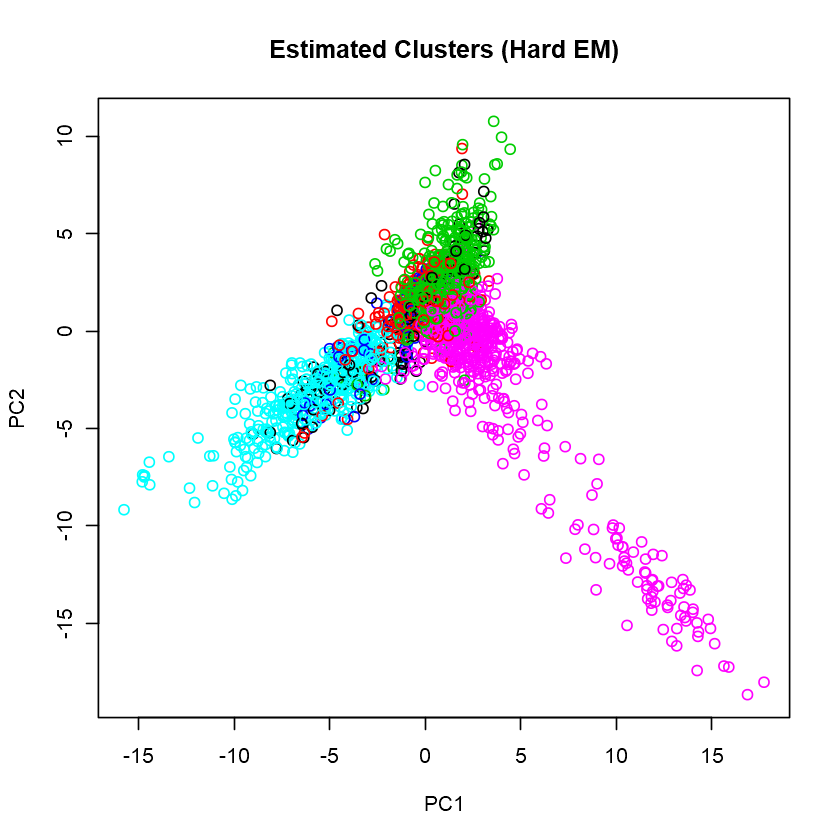

In [12]:
cluster.viz(t(counts), hard.label.hat, 'Estimated Clusters (Hard EM)')

#### Soft EM

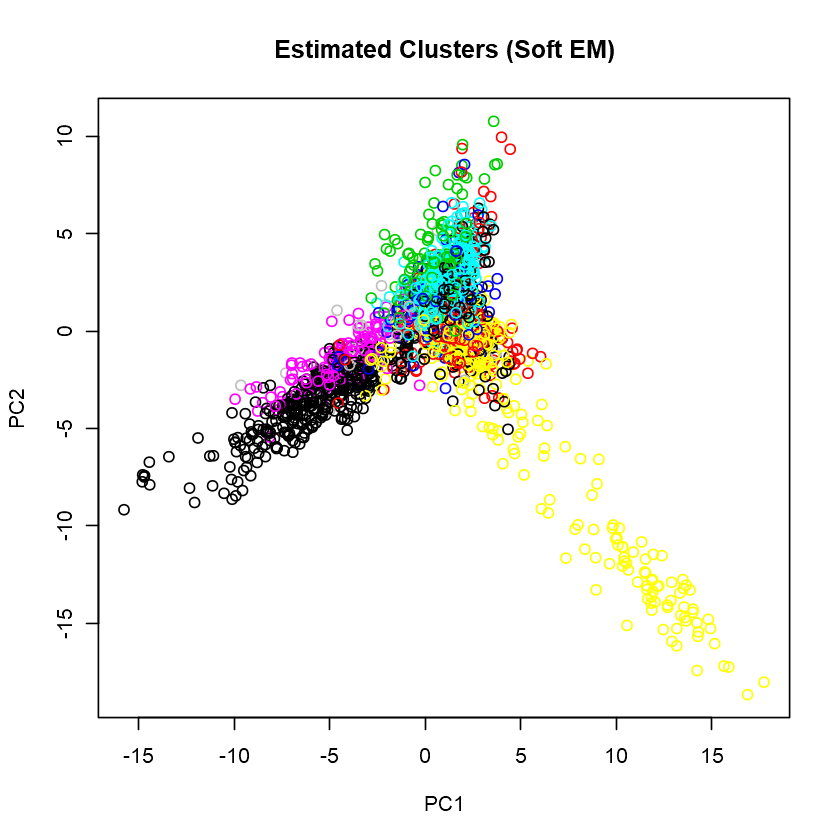

In [16]:
## visualize the stimated clusters
cluster.viz(t(counts), soft.label.hat, 'Estimated Clusters (Soft EM)')

#### Actual Clusters

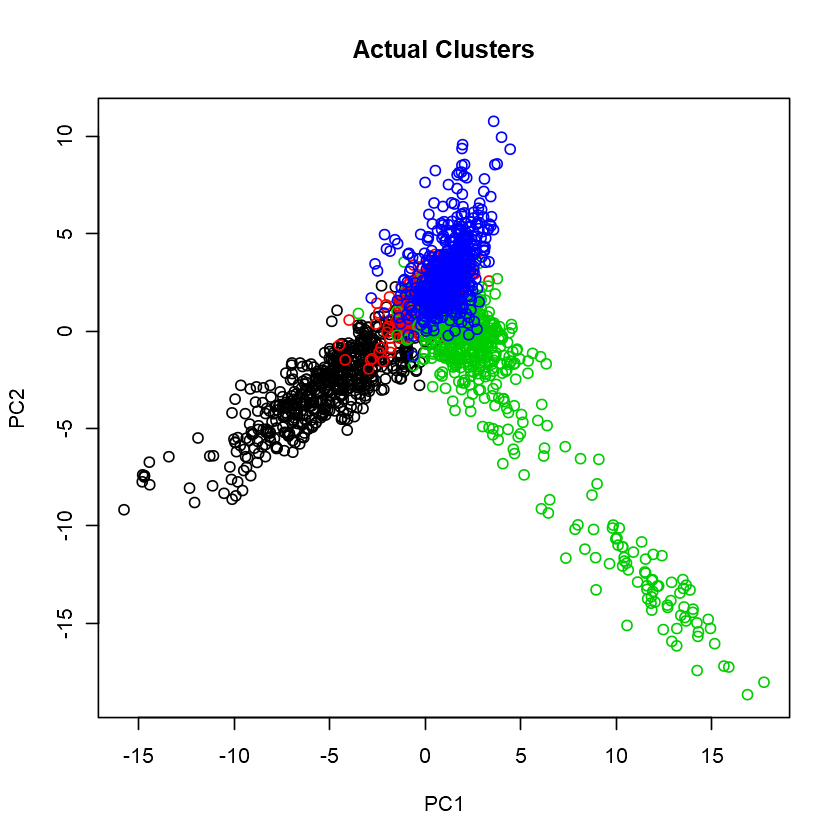

In [14]:
cluster.viz(t(counts), factor(data$labels), "Actual Clusters")